In [2]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [3]:
import os 
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import cv2 as cv
from PIL import Image as PILImage

import torch
from torch import nn
from torch import from_numpy
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms.v2 as transforms
from torchvision.transforms import transforms as T

import albumentations as A

from torch.autograd import detect_anomaly
import evaluate

from transformers import SegformerForSemanticSegmentation, TrainingArguments, \
                        Trainer, SegformerImageProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-06-28 09:30:23.221017: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751103023.419367      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751103023.479134      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
torch.backends.cudnn.benchmark=True  # speeding up training for fixed input size
torch.backends.cudnn.deterministic = False # trading off some randomness for speed

The SegFormer model was proposed in SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers by Enze Xie, Wenhai Wang, Zhiding Yu, Anima Anandkumar, Jose M. Alvarez, Ping Luo. The model consists of a hierarchical Transformer encoder and a lightweight all-MLP decode head to achieve great results on image segmentation benchmarks such as ADE20K and Cityscapes.

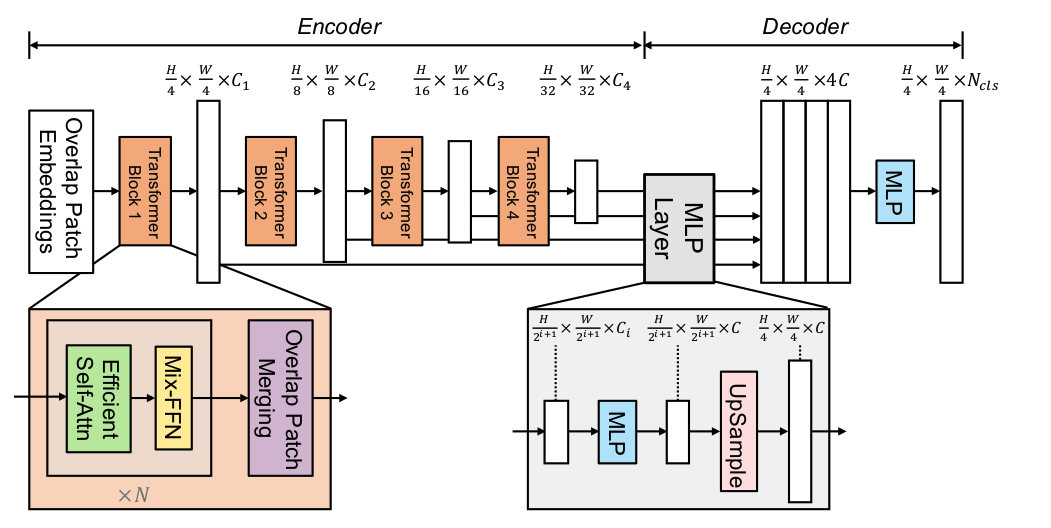

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("franciscoescobar/satellite-images-of-water-bodies")

print("Path to dataset files:", path)

img_folder = path+"/Water Bodies Dataset/Images"
mask_folder = path+"/Water Bodies Dataset/Masks"

images_name = sorted(os.listdir(img_folder))
masks_name = sorted(os.listdir(mask_folder))

image_files_list  = [os.path.join(img_folder,img_name) for img_name in images_name]
mask_files_list  = [os.path.join(mask_folder,mask_name) for mask_name in masks_name]

Path to dataset files: /kaggle/input/satellite-images-of-water-bodies


In [7]:
## setting up labels for the model inference
id2label = {0: 'Not_water', 1: 'water'}
label2id = {label: id for id, label in id2label.items()}
num_labels = 2

In [8]:
MODEL_CHECKPOINT = 'nvidia/mit-b0'  # b1 to b5

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    # ignore_mismatched_sizes=True,
)

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

In [9]:
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  

In [10]:
# class CustomMaskTransform:
#     def __call__(self, image, mask):
#         # Convert 3-channel mask to grayscale by averaging across channels
#         if mask.ndim == 3 and mask.shape[2] == 3:
#             mask = np.mean(mask, axis=2)
            
#         # Apply threshold
#         mask = (mask > 125).astype(np.uint8)
#         return {"image": image, "mask": mask}

# def identity_image_transform(image, **kwargs):
#     return {"image": image}


In [11]:
# Initialize Transformations for Model Training
train_transforms = A.Compose([
    # Resize to 256,256
    A.Resize(560,560,1.0),
    A.CenterCrop(512,512,p=1.0),
    # convert and Normalize 
    A.pytorch.ToTensorV2(),
])

In [10]:
# Load Mean Intersection over Union from Evaluate, Huggingface
metric = evaluate.load('mean_iou')

# Computing Metrics
def compute_metrics(eval_pred):
    # Get Logits and Labels form Predictions
    logits, labels = eval_pred
    logits_tensor = from_numpy(logits)
    # Stack all top classes to pixels with argmax
    logits_tensor = logits_tensor.argmax(1)
    
    pred_labels = logits_tensor.detach().cpu().numpy()
    
    # Compute Loaded Mean IoU 
    metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label), # Sending Number of classes and ignore background IOU calculation
    ignore_index = 0)
    
    # Popping Per category accuracy and IoU to avoid clutter onscreen
    metrics.pop("per_category_accuracy").tolist()
    metrics.pop("per_category_iou").tolist()

    return metrics

In [82]:
import torch.nn.functional as F
class SegFormerTrainerWithCombinedLoss(Trainer):
    def __init__(self, *args, bce_weight=0.5, dice_weight=0.5, **kwargs):
        super().__init__(*args, **kwargs)
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
    
    def dice_loss(self, pred_logits, target, smooth=1e-6):
        """Calculate Dice loss for binary segmentation"""

        pred_probs = F.softmax(pred_logits, dim=1)[:, 0, :, :]

        # Flatten tensors using reshape instead of view
        pred_flat = pred_probs.reshape(-1)
        target_flat = target.reshape(-1).float()
        
        # Calculate dice coefficient
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice_coeff = (2.0 * intersection + smooth) / (union + smooth)
        return 1 - dice_coeff
    
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """Override compute_loss to use combined BCE + Dice loss"""
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        logits_flat = logits[:, 0, :, :]  # Take class 1 (foreground)
        bce_loss = F.binary_cross_entropy_with_logits(logits_flat, labels.float())
        # Calculate Dice loss
        dice_loss_val = self.dice_loss(logits, labels)
        
        # Combine losses
        combined_loss = self.bce_weight * bce_loss + self.dice_weight * dice_loss_val
        
        return (combined_loss, outputs) if return_outputs else combined_loss


In [83]:
#Custom class for loading Dataset
class SemanticSegmentationData(Dataset):
    def __init__(self, image_files_list, mask_files_list, device):
        """
        transforms: Torch transforms for image processing
        images_path, masks_path: image and mask path 
        
        images, masks: list of images and masks (to ease train and test split)
        device: cuda
        """
        self.image_files_list = image_files_list
        self.mask_files_list = mask_files_list
        self.device = device
    

    
    def __getitem__(self,index):
        """
        to Transform Image and mask, organize it to send to the model
        """
        # Read Images and masks
        img = PILImage.open(self.image_files_list[index])
        img = T.Resize((560, 560))(img)
        img = T.CenterCrop((512,512))(img)
        img_tensor = T.ToTensor()(img)
        
        mask = PILImage.open(self.mask_files_list[index])
        mask = T.Resize((560, 560))(mask)
        mask = T.CenterCrop((512,512))(mask)
        mask = T.Resize((128,128))(mask) # Segformer Outputs 128x128 mask, so resizing masks to compare metrics
        mask = np.mean(np.asarray(mask),axis=2)/255.0
        mask_tensor = from_numpy(mask.round().astype(np.int32)).long()
               
        # Organizing Image in 'pixel_values' and mask in 'labels'
        image_tensor = {}
        image_tensor['labels'] = mask_tensor
        image_tensor['pixel_values'] = img_tensor.to(self.device)
        
        return image_tensor
    
    
    def __len__(self):
        # return length of images
        return len(self.image_files_list)

In [84]:
X_train , X_val , y_train, y_val = train_test_split(image_files_list, mask_files_list,test_size = 0.2 , random_state=42)

In [85]:
# Dataset for training
segmentationDataTrain = SemanticSegmentationData(X_train, y_train,device)
segmentationDataVal = SemanticSegmentationData(X_val, y_val,device)

In [87]:
model = model.to(device)

In [90]:
# Hub model ID to upload to Hugging Face HUb
hub_model_id = "SCYS/WaterBodies"

# Initializing Training Arguments
train_args = TrainingArguments(output_dir = "/kaggle/working/",
                               num_train_epochs = 5 , # Number of epochs
                               # max_steps = 500,
                               per_device_train_batch_size = 2, # Batch size
                               save_total_limit = 4,
                               dataloader_pin_memory = False, # DOnot pin to memory, so that torch long() can be used
                               eval_strategy="steps", # Evaluate after certain steps
                               logging_steps = 50, # Number of steps to log and call evaluate/save
                               save_strategy="steps", # save at steps ^
                               load_best_model_at_end=True, # Load the best model at end
                               hub_model_id = hub_model_id, # ID to push to hub
                               report_to="none"  # 
                              )

trainer = SegFormerTrainerWithCombinedLoss(
                model=model, 
                args=train_args,
                train_dataset=segmentationDataTrain,
                # compute_metrics=compute_metrics,
                eval_dataset=segmentationDataVal,
                bce_weight=0.6,  # using same weight as other model
                dice_weight=0.4
            )

In [91]:
trainer.train()

Step,Training Loss,Validation Loss
50,0.318200,0.238174
100,0.238300,0.201789
150,0.315100,0.234154
200,0.258100,0.197086
250,0.243700,0.192522
300,0.228000,0.180599
350,0.251300,0.181701
400,0.221000,0.169623
450,0.239000,0.173355
500,0.215900,0.183607


TrainOutput(global_step=2840, training_loss=0.19470990711534528, metrics={'train_runtime': 8344.2639, 'train_samples_per_second': 1.361, 'train_steps_per_second': 0.34, 'total_flos': 1.9911757472464896e+17, 'train_loss': 0.19470990711534528, 'epoch': 5.0})

During training: Dropout, batch normalization, and other regularization techniques are active, making the model perform "worse" intentionally to prevent overfitting
During validation: Model is in evaluation mode (model.eval()), so dropout is disabled and batch norm uses running statistics

Training: Often includes augmentations (rotations, flips, noise) making examples harder
Validation: Uses original, unaugmented data

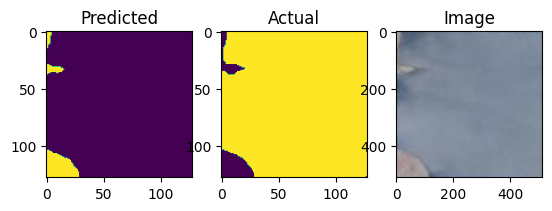

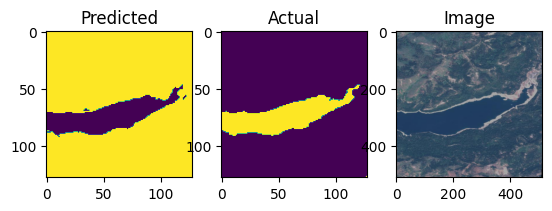

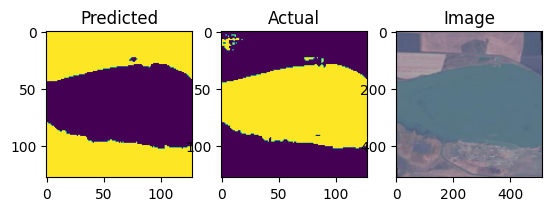

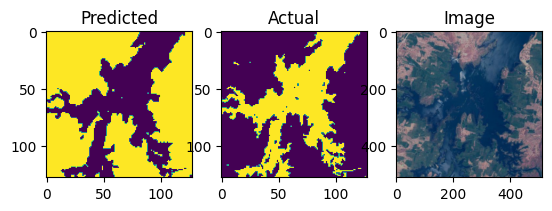

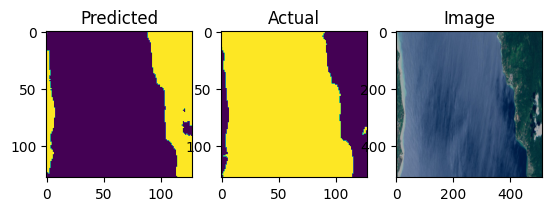

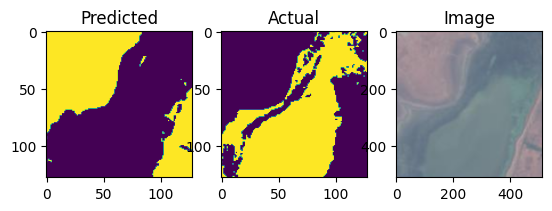

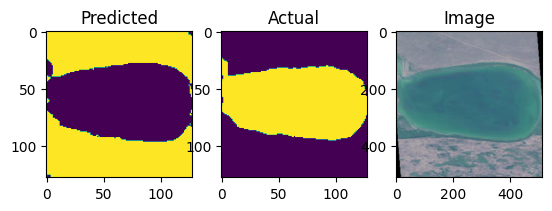

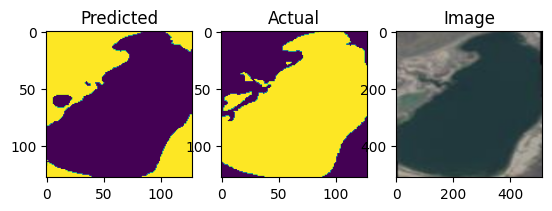

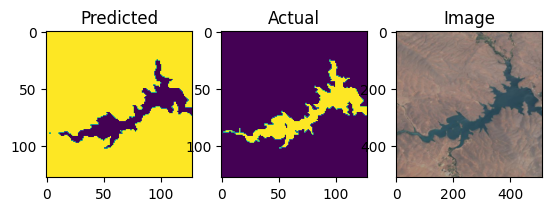

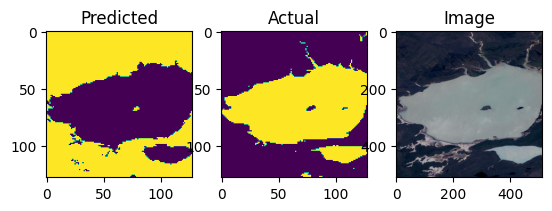

In [92]:
from random import sample
# Visualize the Model 
def visualize_model(images_list):
    for i in images_list:
        temp = i['pixel_values'].unsqueeze(0)
        with model.eval() and torch.no_grad(): # Set evaluation mode without gradient calculation
            out = model(temp) # run the model over data
            output = out.logits.squeeze() # get logits
            output1 = output.argmax(0).detach().cpu()
            fig,axes = plt.subplots(1,3) # Three Columns for pred, actual and Image
            axes[0].set_title("Predicted")
            axes[0].imshow(output1)
            axes[1].set_title("Actual")
            axes[1].imshow(i['labels'].detach().cpu())
            axes[2].set_title("Image")
            axes[2].imshow(temp.detach().cpu().squeeze().permute(1,2,0))
            plt.show()
# Visualizing random 10 images from the complete dataset training
visualize_model([segmentationDataTrain[i] for i in sample(range(0, len(segmentationDataTrain)-30), 10)])


In [ ]:
trainer.evaluate()